<a href="https://colab.research.google.com/github/DGuilherme/PMTese/blob/main/20250426CNNT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow scikit-learn

# Imports
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load Data
column_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f'sensor{i}' for i in range(1, 22)]
train_data = pd.read_csv('/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/train_FD001.txt/train_FD001.txt', delim_whitespace=True, header=None)
test_data = pd.read_csv('/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/test_FD001.txt/test_FD001.txt', delim_whitespace=True, header=None)
rul_data = pd.read_csv('/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/RUL_FD001.txt/RUL_FD001.txt', delim_whitespace=True, header=None)


Mounted at /content/drive


<ipython-input-1-fd8d586e5f51>:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_data = pd.read_csv('/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/train_FD001.txt/train_FD001.txt', delim_whitespace=True, header=None)
<ipython-input-1-fd8d586e5f51>:21: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_data = pd.read_csv('/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/test_FD001.txt/test_FD001.txt', delim_whitespace=True, header=None)
<ipython-input-1-fd8d586e5f51>:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  rul_data = pd.read_csv('/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/RUL_FD001.txt/RUL_FD001.txt'

In [2]:
# Set column names
train_data.columns = column_names
test_data.columns = column_names
rul_data.columns = ['RUL']

# Generate RUL for training data
max_cycle = train_data.groupby('id')['cycle'].max()
train_data = train_data.merge(max_cycle.reset_index(), on='id', suffixes=('', '_max'))
train_data['RUL'] = train_data['cycle_max'] - train_data['cycle']
train_data.drop(columns=['cycle_max'], inplace=True)

# Generate RUL for test data
max_cycle_test = test_data.groupby('id')['cycle'].max().reset_index()
max_cycle_test.columns = ['id', 'max_cycle']
rul_data.columns = ['RUL']
max_cycle_test['RUL'] = rul_data['RUL']
test_data = test_data.merge(max_cycle_test, on='id')
test_data['RUL'] = test_data['RUL'] + test_data['max_cycle'] - test_data['cycle']
test_data.drop(columns=['max_cycle'], inplace=True)

# Select useful features (as suggested in papers)
useful_sensor_cols = ['setting1', 'setting2', 'setting3'] + \
    [f'sensor{i}' for i in [2, 3, 4, 7, 8, 11, 12, 13, 14, 15, 17, 20, 21]]

train_data = train_data[['id', 'cycle'] + useful_sensor_cols + ['RUL']]
test_data = test_data[['id', 'cycle'] + useful_sensor_cols + ['RUL']]

# Normalize sensor values
scaler = MinMaxScaler()
train_data[useful_sensor_cols] = scaler.fit_transform(train_data[useful_sensor_cols])
test_data[useful_sensor_cols] = scaler.transform(test_data[useful_sensor_cols])

# Windowing function
def create_sequences(data, sequence_length=30):
    sequences = []
    labels = []
    engines = data['id'].unique()
    for engine_id in engines:
        engine_data = data[data['id'] == engine_id]
        feature_data = engine_data[useful_sensor_cols].values
        label_data = engine_data['RUL'].values
        for i in range(len(feature_data) - sequence_length + 1):
            sequences.append(feature_data[i:i+sequence_length])
            labels.append(label_data[i+sequence_length-1])
    return np.array(sequences), np.array(labels)

# Create sequences
X_train, y_train = create_sequences(train_data)
X_test, y_test = create_sequences(test_data)

print("Training set:", X_train.shape, y_train.shape)
print("Testing set:", X_test.shape, y_test.shape)



Training set: (17731, 30, 16) (17731,)
Testing set: (10196, 30, 16) (10196,)


In [3]:
# Transformer Encoder
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention block
    attn_output = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    attn_output = layers.Dropout(dropout)(attn_output)
    x = layers.LayerNormalization(epsilon=1e-6)(inputs + attn_output)  # Add & Norm

    # Feed Forward block
    ff_output = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    ff_output = layers.Dropout(dropout)(ff_output)
    ff_output = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(ff_output)
    x = layers.LayerNormalization(epsilon=1e-6)(x + ff_output)  # Add & Norm

    return x



In [4]:
# Build Model
def build_model(input_shape, head_size=64, num_heads=4, ff_dim=128, num_transformer_blocks=2, mlp_units=[128], dropout=0.1, mlp_dropout=0.1):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D()(x)
    for units in mlp_units:
        x = layers.Dense(units, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)  # Predict RUL
    return keras.Model(inputs, outputs)

# Compile Model
input_shape = X_train.shape[1:]  # (window_size, num_features)
model = build_model(input_shape)

model.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mae"]
)

model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 16)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 16)    │     17,168 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 30, 16)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 30, 16)    │          0 │ input_layer[0][0… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 30, 16)    │         32 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 30, 128)   │      2,176 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 30, 128)   │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 30, 16)    │      2,064 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 30, 16)    │          0 │ layer_normalizat… │
│                     │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 16)    │         32 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 16)    │     17,168 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 30, 16)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 30, 16)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 16)    │         32 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 30, 128)   │      2,176 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 30, 128)   │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 30, 16)    │      2,064 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 30, 16)    │          0 │ layer_normalizat… │
│                     │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 16)    │         32 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 45,249 (176.75 KB)

 Trainable params: 45,249 (176.75 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True)



Epoch 1/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 40s 110ms/step - loss: 11150.7510 - mae: 88.2962 - val_loss: 15350.1641 - val_mae: 100.9546
Epoch 2/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 39s 104ms/step - loss: 10633.6094 - mae: 84.9305 - val_loss: 14213.4131 - val_mae: 95.6940
Epoch 3/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 102ms/step - loss: 9540.5527 - mae: 79.1675 - val_loss: 12636.8154 - val_mae: 88.4916
Epoch 4/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 47s 132ms/step - loss: 8267.5625 - mae: 71.7311 - val_loss: 10832.4160 - val_mae: 80.4245
Epoch 5/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 22s 100ms/step - loss: 6739.6611 - mae: 63.7916 - val_loss: 9060.6680 - val_mae: 72.7202
Epoch 6/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - loss: 5437.1938 - mae: 56.9906 - val_loss: 7585.8975 - val_mae: 66.5584
Epoch 7/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 101ms/step - loss: 4331.0850 - mae: 51.0289 - val_loss: 5890.4922 - val_mae: 54.1716
Epoch 8/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - loss: 3034.0403 - mae: 38

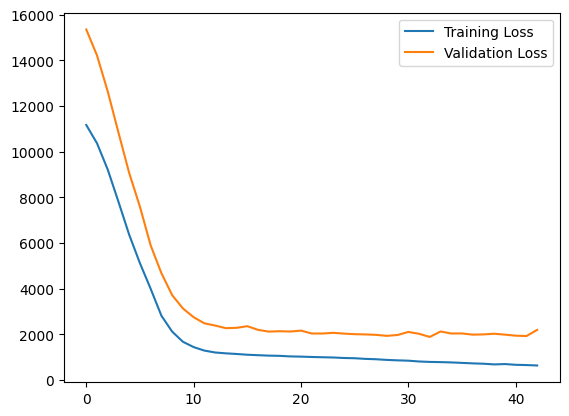

In [6]:
# Train
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping]
)

# Plot loss curves
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend()
plt.show()



319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
Test RMSE: 42.06
Test MAE: 32.09


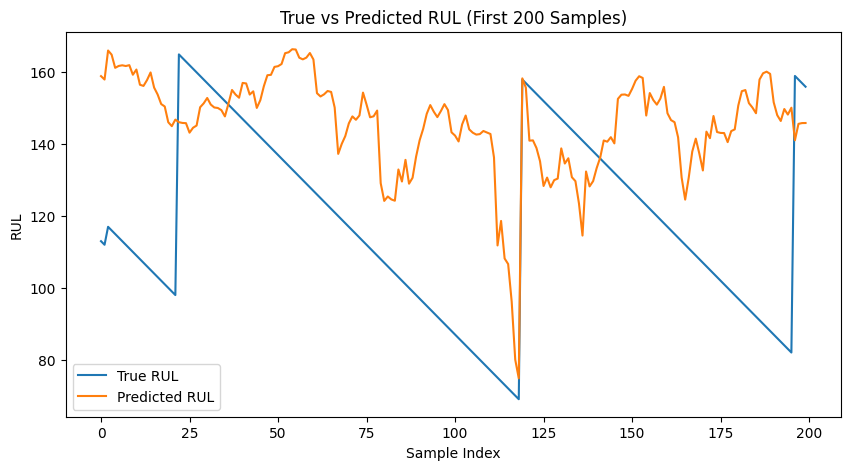

In [7]:
# Evaluate
y_pred = model.predict(X_test).flatten()
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")

# Optional: Plot true vs predicted RUL
plt.figure(figsize=(10,5))
plt.plot(y_test[:200], label="True RUL")
plt.plot(y_pred[:200], label="Predicted RUL")
plt.legend()
plt.xlabel("Sample Index")
plt.ylabel("RUL")
plt.title("True vs Predicted RUL (First 200 Samples)")
plt.show()